Homework 1

Extra Credit: Implement a two-layer neural network from scratch

Name: Gautami Kant
Andrew ID: gkant

In [1]:
# Importing libraries
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Optional, List, Tuple, Dict
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class Transform(object):
    """
    This is the base class. You do not need to change anything.
    Read the comments in this class carefully.
    """
    def __init__(self):
        """
        Initialize any parameters
        """
        pass

    def forward(self, x):
        """
        x should be passed as column vectors
        """
        pass

    def backward(self, grad_wrt_out):
        """
        Compute and save the gradients wrt the parameters for step()
        Return grad_wrt_x which will be the grad_wrt_out for previous Transform
        """
        pass

    def step(self):
        """
        Apply gradients to update the parameters
        """
        pass

    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        pass


In [5]:
# Parameters. Increased the epochs to 700, giving better results compared to 200

indim = 10
outdim = 2
hidden_dim_1 = 100
hidden_dim_2 = 100
lr = 0.01
batch_size = 64
epochs = 700


In [6]:
class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length


In [7]:
# One hot encoding

def labels2onehot(labels: np.ndarray):
    return np.array([[i==lab for i in range(2)] for lab in labels]).astype(int)


In [8]:
if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need plot the loss and accuracies during the training process and test process. 
    """

#Importing training and test datasets

Xtrain = np.loadtxt("/content/drive/MyDrive/NN_HW1/XTrain.txt", delimiter="\t")
Ytrain = np.loadtxt("/content/drive/MyDrive/NN_HW1/yTrain.txt", delimiter="\t").astype(int)
m1, n1 = Xtrain.shape
print(m1, n1)
train_ds = DS(Xtrain, Ytrain)
train_loader = DataLoader(train_ds, batch_size=batch_size)

Xtest = np.loadtxt("/content/drive/MyDrive/NN_HW1/XTest.txt", delimiter="\t")
Ytest = np.loadtxt("/content/drive/MyDrive/NN_HW1/yTest.txt", delimiter="\t").astype(int)
m2, n2 = Xtest.shape
print(m1, n2)
test_ds = DS(Xtest, Ytest)
test_loader = DataLoader(test_ds, batch_size=batch_size)


500 10
500 10


In [9]:
class ReLU(Transform):
    def __init__(self):
        super(ReLU, self).__init__()
        

    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (indim, batch_size)
        """
        self.out = torch.max(x, torch.zeros_like(x))
        return self.out
        

    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
    
        """
        return grad_wrt_out * (self.out > 0.0)


In [10]:
class LinearMap(Transform):
    def __init__(self, indim, outdim, lr=0.001):
        """
        indim: input dimension
        outdim: output dimension
        lr: learning rate
        """
        super(LinearMap, self).__init__()
        self.weights = 0.01 *torch.rand((outdim, indim), dtype=torch.float64, requires_grad=True)
        self.bias = 0.01 * torch.rand((outdim, 1), dtype=torch.float64, requires_grad=True)
        self.lr = lr


    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (outdim, batch_size)
        """
        self.x = x
        return torch.matmul(self.weights, x) + self.bias


    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        return shape (indim, batch_size)
        """
        grad_weights = torch.matmul(grad_wrt_out, self.x.t())
        self.bias.grad = torch.sum(grad_wrt_out, dim=1, keepdim=True)
        grad_wrt_input = torch.matmul(self.weights.t(), grad_wrt_out)
        self.weights.grad = grad_weights
        return grad_wrt_input


    def step(self):
        """
        apply gradients calculated by backward() to update the parameters
        """
        
        self.weights = self.weights - self.lr * self.weights.grad
        self.bias = self.bias - self.lr * self.bias.grad
        
    def zerograd(self):
        if self.weights.grad is not None:
            self.weights.grad.zero_()
        if self.bias.grad is not None:
            self.bias.grad.zero_()

In [11]:
class SingleLayerMLP(Transform):
    """constructing a single layer neural network with the previous functions"""
    def __init__(self, indim, outdim, hidden_layer_1=100, hidden_layer_2=100, lr=0.001):
        super(SingleLayerMLP, self).__init__()
        self.fc1 = LinearMap(indim, hidden_layer_1, lr=lr)
        self.relu1 = ReLU()
        self.fc2 = LinearMap(hidden_layer_1, hidden_layer_2, lr=lr)
        self.relu2 = ReLU()
        self.fc3 = LinearMap(hidden_layer_2, outdim, lr=lr)
        self.criterion = SoftmaxCrossEntropyLoss()
        self.loss = None


    def forward(self, x):
        """
        x shape (indim, batch_size)
        return the presoftmax logits shape(outdim, batch_size)
        """
        out = self.fc1.forward(x)
        out = self.relu1.forward(out)
        out = self.fc2.forward(out)
        out = self.relu2.forward(out)
        out = self.fc3.forward(out)
        return out


    def backward(self,grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        calculate the gradients wrt the parameters
        """
        grad_wrt_out = self.fc3.backward(grad_wrt_out)
        grad_wrt_out = self.relu2.backward(grad_wrt_out)
        grad_wrt_out = self.fc2.backward(grad_wrt_out)
        grad_wrt_out = self.relu1.backward(grad_wrt_out)
        grad_wrt_out = self.fc1.backward(grad_wrt_out)
        return grad_wrt_out

    
    def step(self):
        """update model parameters"""
        self.fc1.step()
        self.relu1.step()
        self.fc2.step()
        self.relu2.step()
        self.fc3.step()


In [12]:
class SoftmaxCrossEntropyLoss(object):
    def __init__(self):
        self.num_classes, self.batch_size = None, None
        
    def forward(self, logits, labels):
        """
        logits are pre-softmax scores, labels are one-hot labels of given inputs
        logits and labels are in the shape of (num_classes, batch_size)
        returns loss as a scalar (i.e. mean value of the batch_size loss)
        """
        self.logits = logits
        self.labels = labels
        self.batch_size = logits.shape[1]
        e_logits = torch.exp(logits)
        self.prob = e_logits / torch.sum(e_logits, dim=0, keepdim=True) 
        logprob = -torch.log(self.prob[labels.argmax(dim=1), range(self.batch_size)])
        return torch.mean(logprob)

    def backward(self):
        """
        return grad_wrt_logits shape (num_classes, batch_size)
        (don't forget to divide by batch_size because your loss is a mean)
        """
        grad_wrt_logits = self.prob.clone()
        grad_wrt_logits[self.labels.argmax(dim=1), range(self.batch_size)] -= 1
        grad_wrt_logits = grad_wrt_logits / self.batch_size
        return grad_wrt_logits
       
    
    def getAccu(self):
        """
        return accuracy here
        """
        label_pr = torch.argmax(self.prob,dim=0) == torch.argmax(self.labels, dim=1)
        n = self.labels.shape[0]
        accuracy = label_pr.sum().item() / n
        return accuracy

In [13]:
#Construct the model
model = SingleLayerMLP(indim, outdim, hidden_dim_1, hidden_dim_2, lr)

#Construct the loss function
loss_function = SoftmaxCrossEntropyLoss()

In [14]:
# Construct the training process
def training_process(train_loader, test_loader, model, loss_function, num_epochs):

    train_size = len(train_loader)
    test_size = len(test_loader)
    train_loss = []
    train_acc = []
    test_loss= []
    test_acc = []
    train_temp = []
    test_temp = []
    epoch_id = []
    
    # Training loop
    for epoch in range(num_epochs):
        train = 0.0
        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.t()
            y = y.t()
            # One hot encoding the y-labels
            y_onehot = torch.from_numpy(labels2onehot(y))
           
            # Forward Pass
            logits = model.forward(X)

            #Calculating loss function
            loss = loss_function.forward(logits, y_onehot)
           
            # Backward pass
            grads = loss_function.backward()
            model.backward(grads)
            
            # Update parameters
            model.step()
            
            train = train + loss.item()
            train_temp.append(loss_function.getAccu())
            
        train_loss.append(train/train_size)
        train_acc.append(np.mean(train_temp))
        
        # Test loop
        test = 0.0
        with torch.no_grad():
          for X, y in test_loader:
            X = X.t()
            y = y.t()

            # One hot encoding
            y = torch.from_numpy(labels2onehot(y))

            # Forward pass
            logits = model.forward(X)
            loss = loss_function.forward(logits, y)
            test = test + loss.item()
            test_temp.append(loss_function.getAccu())
        test_loss.append(test/test_size)
        test_acc.append(np.mean(test_temp))
        epoch_id.append(epoch)

    return train_loss, test_loss, train_acc, test_acc, epoch_id

In [15]:
train_loss, test_loss, train_acc, test_acc, epoch_id = training_process(train_loader, test_loader, model, loss_function, epochs)

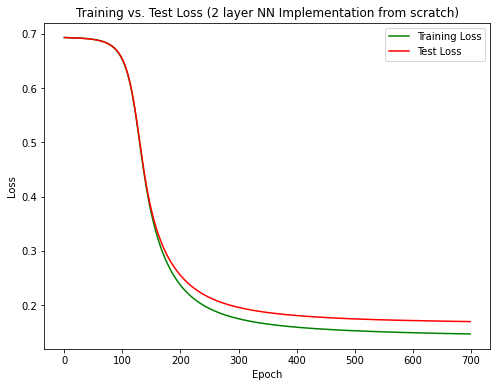

In [16]:
## Plotting training and test loss

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epoch_id, train_loss, color='green',label='Training Loss' )
ax.plot(epoch_id, test_loss, color='red', label = 'Test Loss' )
ax.set(title = "Training vs. Test Loss (2 layer NN Implementation from scratch)",
       xlabel = "Epoch",
       ylabel = "Loss")
plt.legend()
plt.show()

In [17]:
min_train_loss, min_test_loss = min(train_loss), min(test_loss)
min_train_loss, min_test_loss

(0.1469161602713715, 0.16967647768229702)

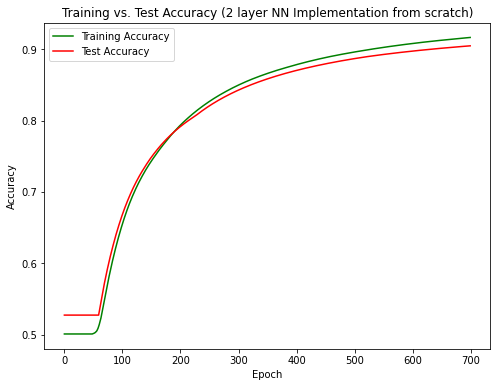

In [18]:
## Plotting training and test accuracies

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epoch_id, train_acc, color='green',label='Training Accuracy' )
ax.plot(epoch_id, test_acc, color='red', label = 'Test Accuracy' )
ax.set(title = "Training vs. Test Accuracy (2 layer NN Implementation from scratch)",
       xlabel = "Epoch",
       ylabel = "Accuracy")
plt.legend()
plt.show()

In [19]:
final_train_accuracy, final_test_accuracy = max(train_acc), max(test_acc)
final_train_accuracy, final_test_accuracy

(0.9163395003434065, 0.9046205357142857)

In [20]:
min(train_acc), min(test_acc)

(0.5009014423076923, 0.52734375)